# p.101 연습
감독자의 체질검사 데이터를 활용하여 체질 비만도를 예측하기 위한 의사결정나무 분석을 실시하고 결과를 해석하시오.
* 목표변수 : FAT(연속형)
* 데이터 비율 train : test = 0.7 : 0.3
* random_state = 1234

# Step 0. 패키지 불러오기

### 나무 시각화 패키지 설치

In [1]:
# !pip install graphviz

### 경로 설정

In [2]:
# os 환경
import os
import sys

# PATH 설정
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

### 패키지 불러오기

In [3]:
# 데이터 구성
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# 한글, 음수 표시
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
# 나무 구조 시각화
import pydot
import graphviz
from sklearn import tree
from graphviz import Source
# 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# 데이터 분리
from sklearn.model_selection import train_test_split
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor as DTR
# GridSearchCV
from sklearn.model_selection import GridSearchCV
# 경고 메시지
import warnings
warnings.filterwarnings('ignore')

# Step 1. 데이터 구성하기

### 데이터 불러오기

In [4]:
df_raw = pd.read_csv('D:/Study/posco/2_bigdata/raw_data/체질검사.csv')
df_raw.head(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8


### 데이터 분리

In [5]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['FAT']
df_raw_x = df_raw.drop('FAT', axis = 1, inplace = False)
# train/test x/y 데이터 분리
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234)
print('train data X size :', df_train_x.shape)
print('train data Y size :', df_train_y.shape)
print('test data X size :', df_test_x.shape)
print('test data Y size :', df_test_y.shape)

train data X size : (176, 13)
train data Y size : (176,)
test data X size : (76, 13)
test data Y size : (76,)


# Step 2. 의사결정나무 모델 생성

### 기본 옵션으로 모델 생성

In [6]:
# 기본 모델
dtr_basic = DTR(random_state = 1234)
dtr_basic.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', dtr_basic.score(df_train_x, df_train_y).round(4))
print('Score in test set :', dtr_basic.score(df_test_x, df_test_y).round(4))

Score in train set : 1.0
Score in test set : 0.3453


* train data에 과대적합

### Hyper Parameter

##### min_samples_leaf : 잎사귀 노드의 최소 자료 수

In [7]:
# train/test 설명력 저장
train_score = []
test_score = []

# min_samples_leaf
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf :
    dtr = DTR(random_state = 1234,
              min_samples_leaf = v_min_samples_leaf)
    dtr.fit(df_train_x, df_train_y)
    train_score.append(dtr.score(df_train_x, df_train_y))
    test_score.append(dtr.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

# 모델 설명력 확인
df_score_leaf.round(4)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.0000,0.3453
1,2,0.9703,0.3738
2,3,0.9275,0.4450
3,4,0.9016,0.4473
4,5,0.8681,0.4508
5,6,0.8512,0.4471
6,7,0.8434,0.4654
7,8,0.8298,0.5358
8,9,0.8023,0.4768
9,10,0.7929,0.5046


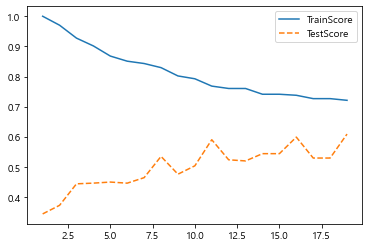

In [8]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = '-', label = 'TrainScore')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'TestScore')
plt.legend();plt.show()

* min_samples_leaf 증가하면 설명력은 감소
* 8, 11, 16 중 하나 선택

##### min_samples_split : 분리 노드의 최소 자료 수

In [9]:
# train/test 설명력 저장
train_score = []
test_score = []

# min_samples_split
para_split = [n_split * 2 for n_split in range(2,20)]

for v_min_samples_split in para_split :
    dtr = DTR(random_state = 1234,
              min_samples_leaf = 8,
              min_samples_split = v_min_samples_split)
    dtr.fit(df_train_x, df_train_y)
    train_score.append(dtr.score(df_train_x, df_train_y))
    test_score.append(dtr.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

# 모델 설명력 확인
df_score_split.round(4)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.8298,0.5358
1,6,0.8298,0.5358
2,8,0.8298,0.5358
3,10,0.8298,0.5358
4,12,0.8298,0.5358
5,14,0.8298,0.5358
6,16,0.8298,0.5358
7,18,0.8205,0.5570
8,20,0.8134,0.5814
9,22,0.7919,0.5675


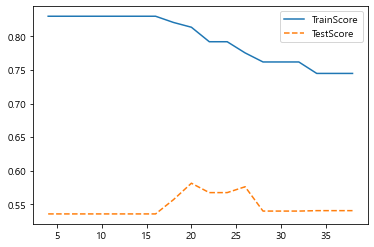

In [10]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = '-', label = 'TrainScore')
plt.plot(para_split, test_score, linestyle = '--', label = 'TestScore')
plt.legend()

* min_samples_split 증가하면 설명력은 감소
* 20, 26 중 하나 선택

##### max_depth : 최대 깊이

In [11]:
# train/test 설명력 저장
train_score = []
test_score = []

# max_depth
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth :
    dtr = DTR(random_state = 1234,
              min_samples_leaf = 8,
              min_samples_split = 20,
              max_depth = v_max_depth)
    dtr.fit(df_train_x, df_train_y)
    train_score.append(dtr.score(df_train_x, df_train_y))
    test_score.append(dtr.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['MaxDepth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

# 모델 설명력 확인
df_score_depth.round(4)

,MaxDepth,TrainScore,TestScore
0,1,0.5165,0.3332
1,2,0.6794,0.5694
2,3,0.7489,0.5377
3,4,0.7831,0.5700
4,5,0.8082,0.5812
5,6,0.8134,0.5814
6,7,0.8134,0.5814
7,8,0.8134,0.5814
8,9,0.8134,0.5814
9,10,0.8134,0.5814


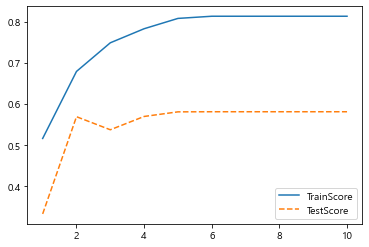

In [12]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = '-', label = 'TrainScore')
plt.plot(para_depth, test_score, linestyle = '--', label = 'TestScore')
plt.legend()

* max_depth 증가하면 설명력은 증가
* 2, 4, 5 중 하나 선택

##### GridSearchCV

In [14]:
estimator = DTR(random_state = 1234)
# parameter
para_grid = {'criterion' : ['mse','friedman_mse','mae'],
             'max_features' : ['auto','sqrt','log2'],
             'min_samples_leaf' : para_leaf,
             'min_samples_split' : para_split,
             'max_depth' : para_depth}
# 설명력이 높은 최적 parameter 찾기
grid_dtr = GridSearchCV(estimator,
                        para_grid,
                        scoring = 'r2',
                        n_jobs = -1)
grid_dtr.fit(df_train_x, df_train_y)
# 결과 확인
print('best estimator model: \n{}'.format(grid_dtr.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dtr.best_params_))
print('\nbest score: \n{}'.format(grid_dtr.best_score_.round(4)))

# Step 3. 최종 모델 선정

### 최종 모델 생성

In [15]:
# 최종 모델
dtr_final = DTR(random_state = 1234,
                min_samples_leaf = 8,
                min_samples_split = 20,
                max_depth = 4)
dtr_final.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', dtr_final.score(df_train_x, df_train_y).round(4))
print('Score in test set :', dtr_final.score(df_test_x, df_test_y).round(4))

Score in train set : 0.7831
Score in test set : 0.57


### 최종 모델 시각화

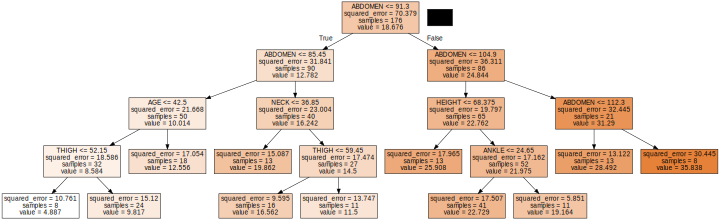

In [16]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 트리 모델 시각화
export_graphviz(dtr_final,
                out_file = 'dtr_final.dot',
                feature_names = v_feature_name,
                impurity = True,
                filled = True)

with open('dtr_final.dot') as f :
    dot_graph = f.read()

pdot = pydot.graph_from_dot_data(dot_graph)
pdot[0].set_graph_defaults(size = "\"10,10\"")
graph = Source(pdot[0].to_string())
graph

# Step 4. 결론 도출

### 설명변수 중요도

In [17]:
# 설명변수 중요도 확인 및 테이블 형태 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = dtr_final.feature_importances_
# 중요도별 정렬
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.895
7,THIGH,0.032
3,NECK,0.026
0,AGE,0.019
2,HEIGHT,0.017
9,ANKLE,0.011
1,WEIGHT,0.000
4,CHEST,0.000
6,HIP,0.000
8,KNEE,0.000


### 설명변수 중요도 그래프

Text(0, 0.5, '변수')

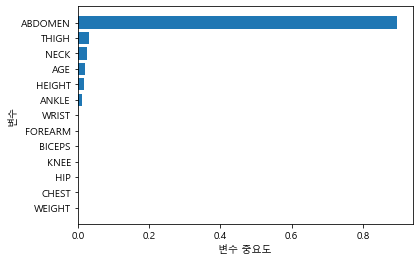

In [18]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

* ABDOMEN, THIGH, NECK 순으로 영향이 크다고 볼 수 있다.